In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm  
import re  
from pypdf import PdfReader
from dotenv import load_dotenv
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
import chromadb 
from groq import Groq
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE

/Users/ranawatprajinrajbhavesh/Desktop/RAG/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()

True

In [3]:
DOCUMENTS_DIR = "pdfs/"
MODEL_NAME = "all-MiniLM-L6-v2"
CHILD_CHUNK_SIZE = 128
PARENT_CHUNK_SIZE = 512
GROQ_MODEL = "meta-llama/llama-4-scout-17b-16e-instruct"
TOP_K = 3

embedding_model = SentenceTransformer(MODEL_NAME)
groq_client = Groq(api_key=os.environ.get("GROQ_API_KEY"))

chroma_client = chromadb.PersistentClient(path="chroma_db")
collection = chroma_client.create_collection(
    name="document_chunks",
    metadata={"hnsw:space": "cosine"}
)


In [4]:
parent_chunks = []
child_to_parent = {}

text_splitter_parent = RecursiveCharacterTextSplitter(
    chunk_size=PARENT_CHUNK_SIZE,
    chunk_overlap=20,
    separators=["\n\n", "\n", ". "]
)

text_splitter_child = RecursiveCharacterTextSplitter(
    chunk_size=CHILD_CHUNK_SIZE,
    chunk_overlap=0,
    separators=["\n", ". ", "! ", "? "]
)

child_counter = 0
for filename in tqdm(os.listdir(DOCUMENTS_DIR), desc="Processing documents"):
    if filename.endswith(".pdf"):
        reader = PdfReader(os.path.join(DOCUMENTS_DIR, filename))
        text = "\n".join([page.extract_text() for page in reader.pages])
        
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'[^\w\s.,;:!?]', '', text)
        
        parents = text_splitter_parent.split_text(text)
        
        for parent_idx, parent in enumerate(parents):
            parent_chunks.append({
                "text": parent,
                "source": filename,
                "parent_id": f"{filename}_parent_{parent_idx}"
            })
            
            children = text_splitter_child.split_text(parent)
            for child in children:
                collection.add(
                    documents=[child],
                    ids=[f"child_{child_counter}"],
                    metadatas={"parent_id": f"{filename}_parent_{parent_idx}"}
                )
                child_to_parent[f"child_{child_counter}"] = len(parent_chunks) - 1
                child_counter += 1


Processing documents:   0%|          | 0/1 [00:00<?, ?it/s]Ignoring wrong pointing object 6 0 (offset 0)
Ignoring wrong pointing object 15 0 (offset 0)
Ignoring wrong pointing object 17 0 (offset 0)
Ignoring wrong pointing object 147 0 (offset 0)
Ignoring wrong pointing object 162 0 (offset 0)
Ignoring wrong pointing object 202 0 (offset 0)
Processing documents: 100%|██████████| 1/1 [00:15<00:00, 15.34s/it]


In [5]:
def retrieve_parent_chunks(question):
    question = re.sub(r'[^\w\s.,;:!?]', '', question)
    results = collection.query(
        query_texts=[question],
        n_results=TOP_K
    )
    parent_indices = set()
    for child_id in results['ids'][0]:
        parent_idx = child_to_parent.get(child_id)
        if parent_idx is not None:
            parent_indices.add(parent_idx)
    return [parent_chunks[i] for i in parent_indices]

def generate_answer(question, context_chunks):
    context = "\n\n".join([f"Source: {chunk['source']}\n{chunk['text']}" for chunk in context_chunks])
    system_prompt = f"""
    You are an expert document assistant. Answer the user's question using ONLY the provided context.
    If the answer isn't in the context, say "I don't know". Be concise and accurate.
    
    Context:
    {context}
    """
    response = groq_client.chat.completions.create(
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": question}
        ],
        model=GROQ_MODEL,
        temperature=0.1,
        max_tokens=512
    )
    return response.choices[0].message.content

def ask_question(question):
    context_chunks = retrieve_parent_chunks(question)
    return generate_answer(question, context_chunks)


In [6]:
pip install seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


Running t-SNE... This may take a moment.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


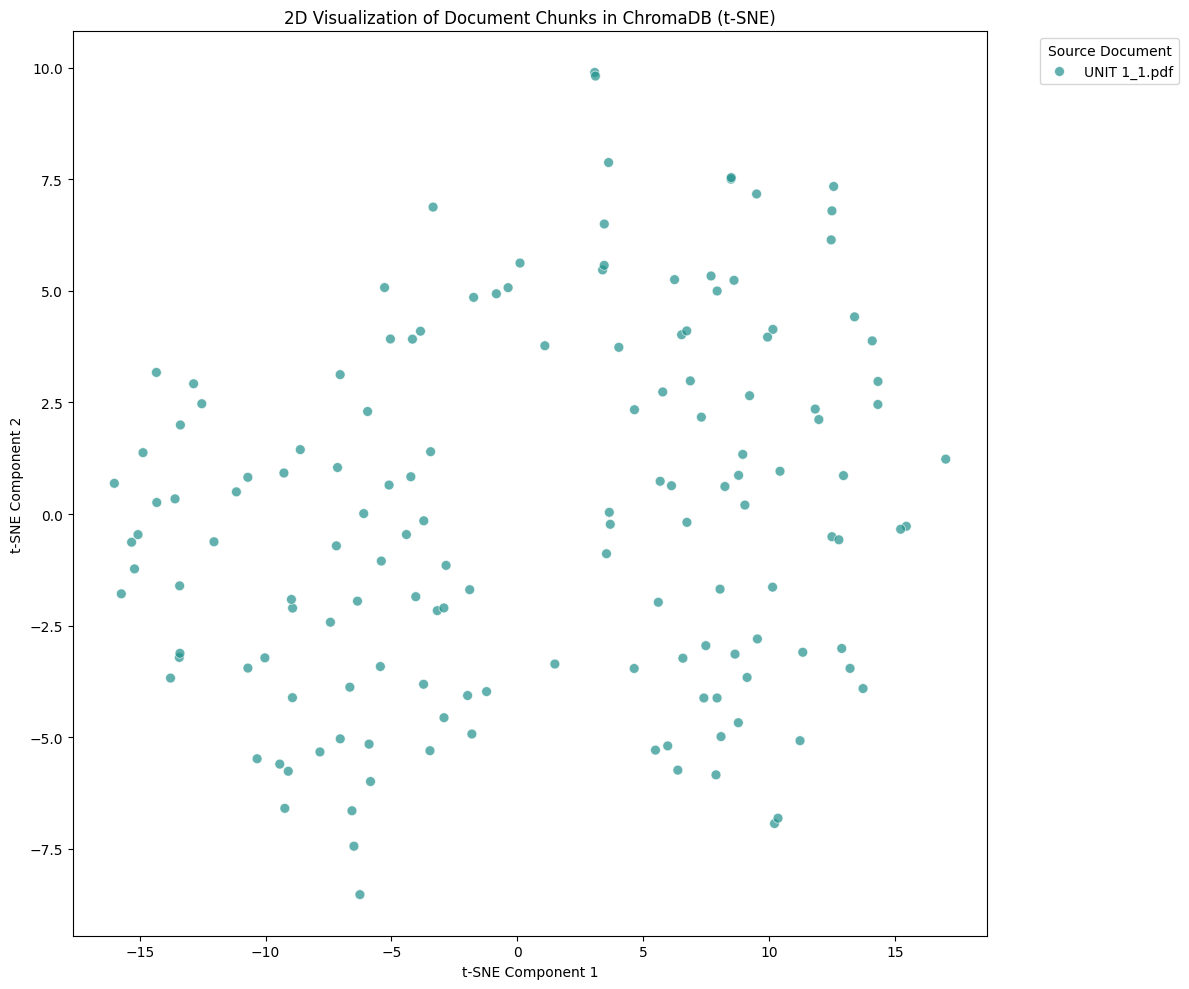

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE

def plot_chroma_db_2d(collection):
    """
    Retrieves embeddings from ChromaDB, reduces them to 2D using t-SNE,
    and creates a scatter plot colored by the source document.
    """
    # 1. Retrieve all embeddings and metadata from the collection
    results = collection.get(include=["embeddings", "metadatas"])

    # --- DEFINITIVE FIX ---
    # This robustly checks if the results dictionary exists and if the 'embeddings' list is populated.
    if not results or 'embeddings' not in results or len(results['embeddings']) == 0:
        print("No embeddings found in the collection. Please process documents first.")
        return

    embeddings = np.array(results['embeddings'])
    parent_ids = [meta['parent_id'] for meta in results['metadatas']]

    # Extract the source filename from the parent_id
    sources = [pid.split('_parent_')[0] for pid in parent_ids]

    # 2. Use t-SNE to reduce dimensions to 2
    print("Running t-SNE... This may take a moment.")
    # Set perplexity based on the number of samples, must be less than n_samples
    perplexity_value = min(30, len(embeddings) - 1)
    if perplexity_value <= 0:
        print("Not enough data points to plot.")
        return
        
    tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    # 3. Create a DataFrame for easy plotting
    df = pd.DataFrame({
        'x': embeddings_2d[:, 0],
        'y': embeddings_2d[:, 1],
        'source': sources
    })

    # 4. Create and display the plot
    plt.figure(figsize=(12, 10))
    sns.scatterplot(
        data=df,
        x='x',
        y='y',
        hue='source',
        palette='viridis',
        alpha=0.7,
        s=50
    )
    plt.title('2D Visualization of Document Chunks in ChromaDB (t-SNE)')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(title='Source Document', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
plot_chroma_db_2d(collection)

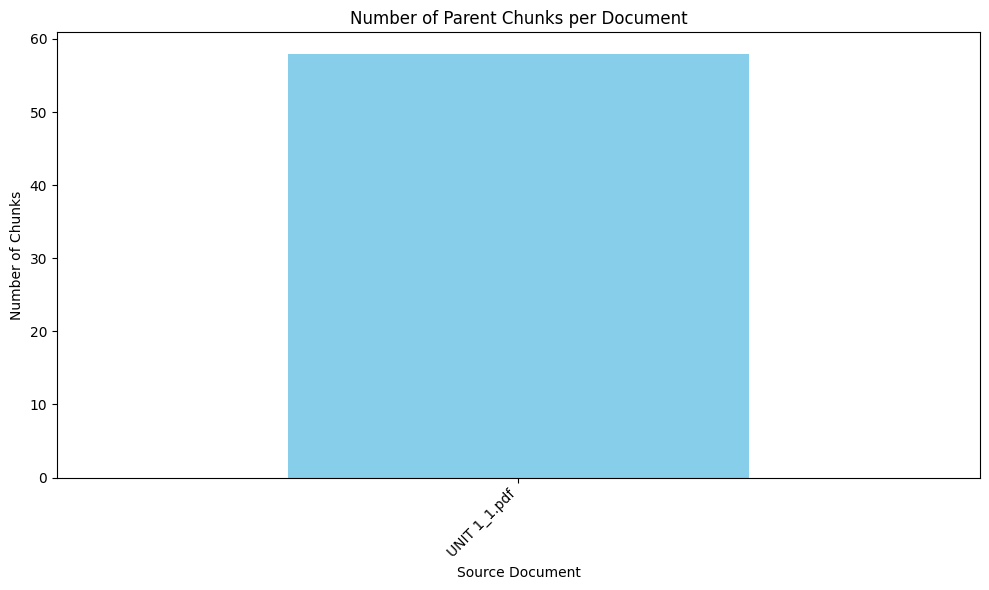

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_chunk_distribution(parent_chunks):
    """
    Creates a bar chart showing the number of parent chunks per source document.
    """
    if not parent_chunks:
        print("No parent chunks found. Please process documents first.")
        return
        
    df = pd.DataFrame(parent_chunks)
    chunk_counts = df['source'].value_counts()
    
    plt.figure(figsize=(10, 6))
    chunk_counts.plot(kind='bar', color='skyblue')
    plt.title('Number of Parent Chunks per Document')
    plt.xlabel('Source Document')
    plt.ylabel('Number of Chunks')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_chunk_distribution(parent_chunks)

In [9]:
class EvaluationSystem:
    def __init__(self):
        self.test_questions = []
    
    def add_test_case(self, question, expected_source, expected_answer):
        self.test_questions.append({
            "question": question,
            "expected_source": expected_source,
            "expected_answer": expected_answer
        })
    
    def evaluate(self):
        hit_count = 0
        reciprocal_ranks = []
        
        for test_case in tqdm(self.test_questions, desc="Evaluating"):
            # Retrieve context chunks
            context_chunks = retrieve_parent_chunks(test_case["question"])
            
            # Check hit rate
            sources = [chunk["source"] for chunk in context_chunks]
            if test_case["expected_source"] in sources:
                hit_count += 1
                
                # Calculate rank
                rank = sources.index(test_case["expected_source"]) + 1
                reciprocal_ranks.append(1/rank)
            else:
                reciprocal_ranks.append(0)
        
        hit_rate = hit_count / len(self.test_questions)
        mrr = sum(reciprocal_ranks) / len(self.test_questions)
        
        return hit_rate, mrr


In [10]:
eval_system = EvaluationSystem()
eval_system.add_test_case(
    "Who is the leader only give name?",
    "Software_Sigmas_ Project Kissan.pdf",  
    "Prajinraj Ranawat"
)



hit_rate, mrr = eval_system.evaluate()
print(f"\nEvaluation Results:")
print(f"Hit Rate: {hit_rate:.2%}")
print(f"MRR: {mrr:.4f}")

Evaluating: 100%|██████████| 1/1 [00:00<00:00,  8.56it/s]


Evaluation Results:
Hit Rate: 0.00%
MRR: 0.0000


# Error thrown below was just a keybord interrupt to terminate the loop

In [11]:
print("\nDocument Q&A System Ready! Ask questions about your documents:")
while True:
    user_question = input("\nAsk a question (type 'exit' to quit): ")
    if user_question.lower() == 'exit':
        break
    answer = ask_question(user_question)
    print(f"\nAnswer: {answer}")


Document Q&A System Ready! Ask questions about your documents:

Answer: Here's an overview based on the provided context:

**Security Overview**

* **Security Service**: Overall security functions and objectives (the "what" of security)
* **Security Mechanism**: The methods and techniques used to implement security (the "how" of security)

**Types of Security Attacks**

* **Passive Attacks**: Attempt to learn or make use of information without affecting system resources
	+ Examples: Eavesdropping, Traffic analysis, Port Scanning, Keylogging
* **Active Attacks**: Attempt to alter system resources or affect their operation
	+ Examples: Masquerade (impersonating a legitimate user)

Answer: You're welcome! Is there anything else I can help you with regarding the provided text about cryptography and substitution techniques?

Answer: I'm a document assistant trained on the provided context from UNIT1_1.pdf, which appears to be related to computer security, authentication, and data integrity

KeyboardInterrupt: Interrupted by user